# Домашнее задание

1. Попробуйте обучить нейронную сеть GRU/LSTM для предсказания сентимента сообщений с твитера на примере https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech

2. Опишите, какой результат вы получили? Что помогло вам улучшить ее точность?

У кого нет возможности работать через каггл (нет верификации), то можете данные взять по ссылке: https://drive.google.com/file/d/1czQcI0Zgvgo6DjW1-yTFUhL8_XVsF6vi/view?usp=sharing

In [1]:
pip install stop_words

  Preparing metadata (setup.py) ... done
  Created wheel for stop_words: filename=stop_words-2018.7.23-py3-none-any.whl size=32895 sha256=a4376dc572df9ba8700a637a1f2dc213f2dd7e6b25a02e2cb5f646351de77966
  Stored in directory: /root/.cache/pip/wheels/d0/1a/23/f12552a50cb09bcc1694a5ebb6c2cd5f2a0311de2b8c3d9a89
Successfully built stop_words


In [2]:
pip install pymorphy3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.2/53.2 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 56.9 MB/s eta 0:00:00


In [3]:
import pandas as pd
from string import punctuation
from stop_words import get_stop_words
from pymorphy3 import MorphAnalyzer
import re
from sklearn.model_selection import train_test_split

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from collections import Counter
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

In [4]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [61]:
df = pd.read_csv("dataset.csv")
df['humor'].replace({False:0, True:1}, inplace=True)
df.head(5)

,text,humor
0,"Joe biden rules out 2020 bid: 'guys, i'm not r...",0
1,Watch: darvish gave hitter whiplash with slow ...,0
2,What do you call a turtle without its shell? d...,1
3,5 reasons the 2016 election feels so personal,0
4,"Pasco police shot mexican migrant from behind,...",0


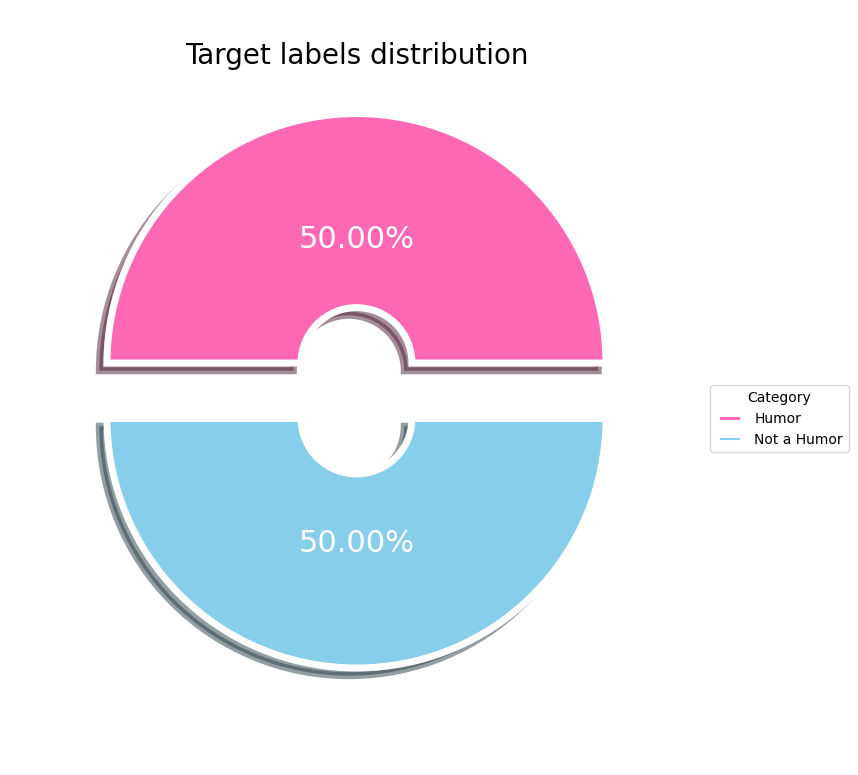

In [62]:
plt.subplots(figsize=(9, 9))

labels = "Humor","Not a Humor"
size = 0.7

wedges, texts, autotexts = plt.pie([len(df[df["humor"]==1]["humor"]),
                                    len(df[df["humor"]==0]["humor"])],
                                    explode = (0.2,0),
                                    textprops=dict(size= 22, color= "white"), # размер и цвет текста внутри диаграмы
                                    autopct="%.2f%%",
                                    pctdistance = 0.5, # положение текста значение процентов
                                    radius=0.9,
                                    shadow = True, # добовляет эфект тени к диаграме
                                    wedgeprops=dict(width = size, edgecolor = "white",
                                    linewidth = 5), # круг добовляет в центре
                                    startangle = 0, colors= ['hotpink', 'skyblue'])

plt.legend(wedges, labels, title="Category",loc="center left",bbox_to_anchor=(1, 0, 0.5, 1))
plt.title("\nTarget labels distribution",fontsize=20)
plt.show()

In [63]:
df.info() # иногда не прогружается полностью в колаб

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    200000 non-null  object
 1   humor   200000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.1+ MB


In [64]:
sw = list(set(get_stop_words("en")))
extra_sw = ['s','d', 'l', 'i',
            're', 've', 'll',  'w', 'cant', 'dont', '']
sw_ = sw+extra_sw
morpher = MorphAnalyzer()

def preprocess_text(txt):

    txt = str(txt)

    txt = re.sub('[%s]' % re.escape(""""#$%&'*+,-./:;<=>@[\]^_`{|}~"""), '', txt) # удалит символы пунктуации
    txt = bytes(txt, encoding='utf8')
    txt = txt.decode("unicode_escape")

    txt = "".join(c for c in txt)
    txt = re.sub('[^A-Za-z0-9]+', ' ', txt)
    txt = txt.lower()
    txt = re.sub('\s+', ' ', txt) # заменит пробельные символы на 1 пробел
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw_]
    return " ".join(txt)

df['text'] = df['text'].apply(preprocess_text)

df['text'].head()

0             joe biden rules 2020 bid guys im running
1        watch darvish gave hitter whiplash slow pitch
2                       call turtle without shell dead
3               5 reasons 2016 election feels personal
4    pasco police shot mexican migrant behind new a...
Name: text, dtype: object

## Разделение на тест и трейн

In [65]:
def triple_split(data, t_size, v_size):
    return np.split(
        data.sample(frac=1, random_state=123),
        [int(len(data)*t_size),
         int(len(data)*(t_size+v_size))]
    )

df_train, df_test, df_val = triple_split(df, 0.60, 0.20)
df_train.shape,  df_test.shape, df_val.shape,

((120000, 2), (40000, 2), (40000, 2))

In [66]:
text_corpus_train = df_train['text'].values
text_corpus_valid = df_val['text'].values
text_corpus_test = df_test['text'].values

counts = Counter()
for sequence in text_corpus_train:
    counts.update(sequence.split())

print("num_words before:",len(counts.keys()))
for word in list(counts):
    if counts[word] < 2:
        del counts[word]
print("num_words after:",len(counts.keys()))

vocab2index = {"":0, "UNK":1}
words = ["", "UNK"]
for word in counts:
    vocab2index[word] = len(words)
    words.append(word)

num_words before: 55964
num_words after: 29302


In [67]:
from functools import lru_cache # для оптимального запоминания

class TextDataset(torch.utils.data.Dataset):

    def __init__(self, txts, labels, w2index, used_length):
        self._txts = txts
        self._labels = labels
        self._length = used_length
        self._w2index = w2index

    def __len__(self):
        return len(self._txts)

    @lru_cache(50000)
    def encode_sentence(self, txt):
        encoded = np.zeros(self._length, dtype=int)
        enc1 = np.array([self._w2index.get(word, self._w2index["UNK"]) for word in txt.split()])
        length = min(self._length, len(enc1))
        encoded[:length] = enc1[:length]
        return encoded, length

    def __getitem__(self, index):
        encoded, length = self.encode_sentence(self._txts[index])
        return torch.from_numpy(encoded.astype(np.int64)), self._labels[index], length

In [68]:
MAX_LEN = max([len(i.split()) for i in text_corpus_train])
BATCH_SIZE = 1024
MAX_LEN

16

In [69]:
MAX_LEN = max([len(i.split()) for i in text_corpus_train])
y_train = df_train['humor'].values
y_val = df_val['humor'].values

train_dataset = TextDataset(text_corpus_train, y_train, vocab2index, MAX_LEN)
valid_dataset = TextDataset(text_corpus_valid, y_val, vocab2index, MAX_LEN)

train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=1)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=1, drop_last=True)


In [70]:
def nn_train(model, criterion, optimizer, device, epochs = 20):
  model = model.to(device)
  model.train()
  th = 0.5

  train_loss_history = []
  test_loss_history = []

  for epoch in range(epochs):
      model.train()
      running_items, running_right = 0.0, 0.0
      for i, data in enumerate(train_loader, 0):
          inputs, labels = data[0].to(device), data[1].to(device)

          optimizer.zero_grad()
          outputs = model(inputs)

          loss = criterion(outputs, labels.float().view(-1, 1))
          loss.backward()
          optimizer.step()

          # get train loss
          loss = loss.item()
          running_items += len(labels)
          # get train acc
          pred_labels = torch.squeeze((outputs > th).int())
          running_right += (labels == pred_labels).sum()

      # validation stats logging
      model.eval()

      print(f'Epoch [{epoch + 1}/{epochs}]. ' \
              f'Step [{i + 1}/{len(train_loader)}]. ' \
              f'Loss: {loss:.3f}. ' \
              f'Acc: {running_right / running_items:.3f}', end='. ')
      running_loss, running_items, running_right = 0.0, 0.0, 0.0
      train_loss_history.append(loss)

      # test stats logging
      test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
      for j, data in enumerate(valid_loader):
          test_labels = data[1].to(device)
          test_outputs = model(data[0].to(device))

          # get test loss
          test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
          # get test acc
          test_running_total += len(data[1])
          pred_test_labels = torch.squeeze((test_outputs > th).int())
          test_running_right += (test_labels == pred_test_labels).sum()

      test_loss_history.append(test_loss.item())
      print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}')

  print('Training is finished!')
  return train_loss_history, test_loss_history

## Ванильная рекурентная сеть

In [74]:
class RNNFixedLen(nn.Module) :

    def __init__(self, vocab_size, embedding_dim, hidden_dim, use_last=True) :
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.18)

    def forward(self, x):
        #x = torch.tensor(x).to(torch.float64)#  иначе идет нарушение типа данных и не работает(
        x = self.embeddings(x)
        x = self.dropout(x)
        out, ht = self.rnn(x)
        if self.use_last:
            last_tensor = out[:,-1,:]
        else:
            # use mean
            last_tensor = torch.mean(out[:,:], dim=1)

        out = self.linear(last_tensor)
        # print(out.shape)
        out = torch.sigmoid(out) #
        return out


In [98]:
vanila = RNNFixedLen(len(vocab2index), 64, 32, use_last=True)
optimizer = torch.optim.NAdam(vanila.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [99]:
train_loss_history_vanila, test_loss_history_vanila = nn_train(vanila, criterion, optimizer, device, epochs = 20)

Epoch [1/20]. Step [118/118]. Loss: 0.550. Acc: 0.642. Test loss: 0.571. Test acc: 0.744
Epoch [2/20]. Step [118/118]. Loss: 0.421. Acc: 0.781. Test loss: 0.412. Test acc: 0.825
Epoch [3/20]. Step [118/118]. Loss: 0.417. Acc: 0.827. Test loss: 0.353. Test acc: 0.848
Epoch [4/20]. Step [118/118]. Loss: 0.309. Acc: 0.850. Test loss: 0.340. Test acc: 0.861
Epoch [5/20]. Step [118/118]. Loss: 0.328. Acc: 0.868. Test loss: 0.297. Test acc: 0.875
Epoch [6/20]. Step [118/118]. Loss: 0.255. Acc: 0.878. Test loss: 0.303. Test acc: 0.877
Epoch [7/20]. Step [118/118]. Loss: 0.290. Acc: 0.886. Test loss: 0.318. Test acc: 0.877
Epoch [8/20]. Step [118/118]. Loss: 0.263. Acc: 0.896. Test loss: 0.261. Test acc: 0.886
Epoch [9/20]. Step [118/118]. Loss: 0.228. Acc: 0.901. Test loss: 0.257. Test acc: 0.889
Epoch [10/20]. Step [118/118]. Loss: 0.185. Acc: 0.907. Test loss: 0.261. Test acc: 0.896
Epoch [11/20]. Step [118/118]. Loss: 0.131. Acc: 0.912. Test loss: 0.254. Test acc: 0.900
Epoch [12/20]. Step

## LSTM

In [95]:
class LSTM(nn.Module) :
    def __init__(self, vocab_size, embedding_dim=64, hidden_dim=32, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        #x = torch.tensor(x).to(torch.int64)#  иначе идет нарушение типа данных и не работает(
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, ht = self.lstm(x)

        if self.use_last:
            last_tensor = lstm_out[:,-1,:]
        else:
            # use mean
            last_tensor = torch.mean(lstm_out[:,:], dim=1)

        out = self.linear(last_tensor)
        # print(out.shape)
        return torch.sigmoid(out)

In [96]:
lstm = LSTM(len(vocab2index))
optimizer = torch.optim.NAdam(lstm.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [97]:
train_loss_history_lstm, test_loss_history_lstm = nn_train(lstm, criterion, optimizer, device, epochs = 20)

Epoch [1/20]. Step [118/118]. Loss: 0.395. Acc: 0.690. Test loss: 0.479. Test acc: 0.794
Epoch [2/20]. Step [118/118]. Loss: 0.358. Acc: 0.828. Test loss: 0.333. Test acc: 0.853
Epoch [3/20]. Step [118/118]. Loss: 0.418. Acc: 0.856. Test loss: 0.347. Test acc: 0.857
Epoch [4/20]. Step [118/118]. Loss: 0.343. Acc: 0.874. Test loss: 0.301. Test acc: 0.879
Epoch [5/20]. Step [118/118]. Loss: 0.281. Acc: 0.884. Test loss: 0.279. Test acc: 0.888
Epoch [6/20]. Step [118/118]. Loss: 0.243. Acc: 0.893. Test loss: 0.272. Test acc: 0.890
Epoch [7/20]. Step [118/118]. Loss: 0.239. Acc: 0.899. Test loss: 0.251. Test acc: 0.894
Epoch [8/20]. Step [118/118]. Loss: 0.266. Acc: 0.904. Test loss: 0.251. Test acc: 0.899
Epoch [9/20]. Step [118/118]. Loss: 0.196. Acc: 0.909. Test loss: 0.245. Test acc: 0.901
Epoch [10/20]. Step [118/118]. Loss: 0.242. Acc: 0.913. Test loss: 0.241. Test acc: 0.903
Epoch [11/20]. Step [118/118]. Loss: 0.145. Acc: 0.917. Test loss: 0.247. Test acc: 0.904
Epoch [12/20]. Step

##GRU

In [92]:
class GRU(nn.Module) :
    def __init__(self, vocab_size, embedding_dim=64, hidden_dim=32, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=2, batch_first=True, )
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        gru_out, ht = self.gru(x)

        if self.use_last:
            last_tensor = gru_out[:,-1,:]
        else:
            # use mean
            last_tensor = torch.mean(gru_out[:,:], dim=1)

        out = self.linear(last_tensor)
        return torch.sigmoid(out)

In [100]:
gru = GRU(len(vocab2index), use_last=True)
optimizer = torch.optim.NAdam(gru.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [101]:
train_loss_history_gru, test_loss_history_gru = nn_train(gru, criterion, optimizer, device, epochs = 20)

Epoch [1/20]. Step [118/118]. Loss: 0.438. Acc: 0.672. Test loss: 0.392. Test acc: 0.818
Epoch [2/20]. Step [118/118]. Loss: 0.342. Acc: 0.826. Test loss: 0.319. Test acc: 0.862
Epoch [3/20]. Step [118/118]. Loss: 0.293. Acc: 0.857. Test loss: 0.288. Test acc: 0.874
Epoch [4/20]. Step [118/118]. Loss: 0.295. Acc: 0.872. Test loss: 0.275. Test acc: 0.884
Epoch [5/20]. Step [118/118]. Loss: 0.337. Acc: 0.883. Test loss: 0.263. Test acc: 0.892
Epoch [6/20]. Step [118/118]. Loss: 0.247. Acc: 0.892. Test loss: 0.246. Test acc: 0.895
Epoch [7/20]. Step [118/118]. Loss: 0.334. Acc: 0.899. Test loss: 0.258. Test acc: 0.893
Epoch [8/20]. Step [118/118]. Loss: 0.254. Acc: 0.903. Test loss: 0.251. Test acc: 0.896
Epoch [9/20]. Step [118/118]. Loss: 0.222. Acc: 0.909. Test loss: 0.232. Test acc: 0.901
Epoch [10/20]. Step [118/118]. Loss: 0.196. Acc: 0.914. Test loss: 0.239. Test acc: 0.903
Epoch [11/20]. Step [118/118]. Loss: 0.194. Acc: 0.916. Test loss: 0.242. Test acc: 0.901
Epoch [12/20]. Step

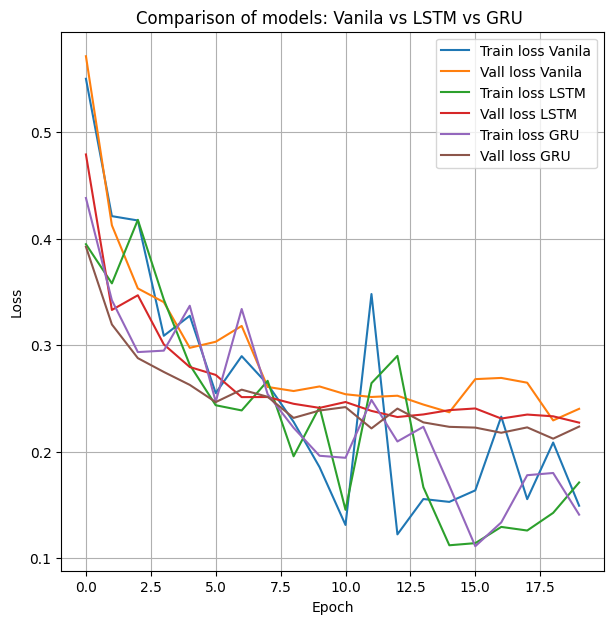

In [102]:
plt.figure(figsize = (7, 7))
plt.plot(train_loss_history_vanila, label = 'Train loss Vanila')
plt.plot(test_loss_history_vanila, label = 'Vall loss Vanila')

plt.plot(train_loss_history_lstm, label = 'Train loss LSTM')
plt.plot(test_loss_history_lstm, label = 'Vall loss LSTM')

plt.plot(train_loss_history_gru, label = 'Train loss GRU')
plt.plot(test_loss_history_gru, label = 'Vall loss GRU')
plt.grid()
plt.legend()
plt.title('Сomparison of models: Vanila vs LSTM vs GRU ')
plt.xlabel('Epoch')
plt.ylabel('Loss');

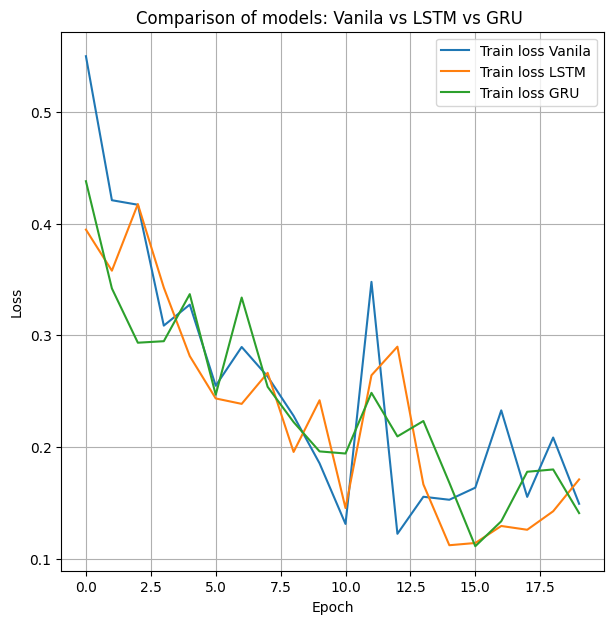

In [103]:
plt.figure(figsize = (7, 7))
plt.plot(train_loss_history_vanila, label = 'Train loss Vanila')

plt.plot(train_loss_history_lstm, label = 'Train loss LSTM')

plt.plot(train_loss_history_gru, label = 'Train loss GRU')
plt.grid()
plt.legend()
plt.title('Сomparison of models: Vanila vs LSTM vs GRU ')
plt.xlabel('Epoch')
plt.ylabel('Loss');

# Выводы
* Скорость обучения у GRU и Lstm значительно ниже чем у обычной рекурентной сети.
* Динамика снижения потерь в задаче класификации на 2 класса для текстового вектора максимальной длиной 16, у простой рекурентной сети показывают вполне неплохие результаты. В данной задаче использование более тяжелых алгоритмов не показывает существеных преимуществ.
* В целом все три модели показали схожую динамику уменьшения потерь. Оптимальной сетью для данной задачи является простая рекурентная сеть.  
Рекурентная нейроная сеть неплохо запоминает вектор длиной 16 элементов.
* GRU или Lstm лучше использовать для задач в которых больше контекста и изначальные текстовые данные представляют собой вектор большей длины, а так же для задач генерации текста.

# Домашнее задание

1. Попробуйте обучить нейронную сеть GRU/LSTM для предсказания сентимента сообщений с твитера на примере https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech

2. Опишите, какой результат вы получили? Что помогло вам улучшить ее точность?

У кого нет возможности работать через каггл (нет верификации), то можете данные взять по ссылке: https://drive.google.com/file/d/1czQcI0Zgvgo6DjW1-yTFUhL8_XVsF6vi/view?usp=sharing

https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/